# Integrating PPI data to identify OPC-endothelial cell interactors

In [1]:
import urllib
import os

import pandas
import numpy

import collections

%matplotlib inline

In [2]:
url_to_path = {
    # STRING PPI
    'http://string.embl.de/newstring_download/protein.aliases.v10/10090.protein.aliases.v10.txt.gz':
        os.path.join('download', 'string', '10090.protein.aliases.v10.txt.gz'),
    'http://string.embl.de/newstring_download/protein.links.v10/10090.protein.links.v10.txt.gz':
        os.path.join('download', 'string', '10090.protein.links.v10.txt.gz'),
}

for url, path in url_to_path.items():
    if not os.path.exists(path):
        urllib.request.urlretrieve(url, path)

## Read and prepare STRING

In [3]:
path = os.path.join('download', 'string', '10090.protein.aliases.v10.txt.gz')
alias_df = pandas.read_table(path, skiprows=1, names = ['string_protein_id', 'alias', 'source'])

In [4]:
alias_df = alias_df.query("source == 'BLAST_KEGG_NAME BLAST_UniProt_GN Ensembl_EntrezGene Ensembl_IKMCs_ES_cells_available Ensembl_MGI Ensembl_UniProt_GN Ensembl_WikiGene'")
alias_df = alias_df[['string_protein_id', 'alias']]

In [5]:
path = os.path.join('download', 'string', '10090.protein.links.v10.txt.gz')
string_df = pandas.read_table(path, sep=' ')

In [6]:
string_df = string_df.merge(
    alias_df.rename(columns={'string_protein_id': 'protein1', 'alias': 'name_a'})).merge(
    alias_df.rename(columns={'string_protein_id': 'protein2', 'alias': 'name_b'}))

string_df = string_df[['name_a', 'name_b', 'combined_score']].drop_duplicates()
string_df = string_df.sort_values(['name_a', 'name_b'])
string_df.head(2)

,name_a,name_b,combined_score
3478100,0610007P14Rik,2610028H24Rik,648
3849791,0610007P14Rik,Aacs,153


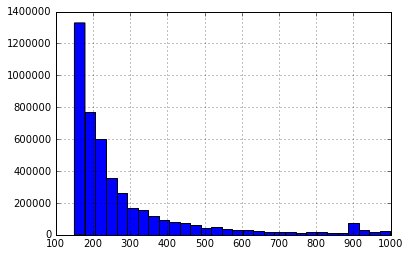

In [7]:
string_df.combined_score.hist(bins=30);

## Integrate expression and GO data

In [8]:
# Parameters
fc_cutoff = 1.5
go_names = [
    'cell surface',
]

In [9]:
fc_df = pandas.read_table('data/enrichment.tsv')
fc_df.head(2)

,Gene symbol,Description,Astrocytes,Neuron,Oligodendrocyte Precursor Cell,Newly Formed Oligodendrocyte,Myelinating Oligodendrocytes,Microglia,Endothelial Cells,cell-cell adhesion,cell surface,opc_fold_change,endothelial_fold_change
0,0610005C13Rik,NaN,0.15096,0.100,0.100,0.100,0.100,0.100,0.100,0,0,0.00000,-0.11760
1,0610007C21Rik,NaN,44.89100,34.185,71.221,57.986,54.006,89.145,63.561,0,0,0.39919,0.11792


In [10]:
fc_df = fc_df.query("opc_fold_change >= @fc_cutoff or endothelial_fold_change >= @fc_cutoff")
for go_name in go_names:
    fc_df = fc_df[fc_df[go_name] == 1]
    
len(fc_df)

380

In [11]:
fc_df = fc_df[['Gene symbol', 'opc_fold_change', 'endothelial_fold_change']]
ixn_df = string_df.merge(
    fc_df.rename(columns={'Gene symbol': 'name_a', 'opc_fold_change': 'opc_fc_a', 'endothelial_fold_change': 'endo_fc_a'})).merge(
    fc_df.rename(columns={'Gene symbol': 'name_b', 'opc_fold_change': 'opc_fc_b', 'endothelial_fold_change': 'endo_fc_b'}))

In [12]:
ixn_df.head()

,name_a,name_b,combined_score,opc_fc_a,endo_fc_a,opc_fc_b,endo_fc_b
0,Abca1,Abcb1a,322,5.6812,1.5247,2.0657,8.4974
1,Ace,Abcb1a,266,4.0414,1.2010,2.0657,8.4974
2,Ace2,Abcb1a,159,1.5925,4.8371,2.0657,8.4974
3,Anxa5,Abcb1a,307,-1.6208,2.9821,2.0657,8.4974
4,Apoa1,Abcb1a,521,1.3615,1.9377,2.0657,8.4974


In [13]:
len(ixn_df)

8630

## Filter for candidate interactions

In [20]:
filtered_df = ixn_df.query(
    "combined_score >= 500 and ((opc_fc_a >= @fc_cutoff and endo_fc_b >= @fc_cutoff) or (opc_fc_b >= @fc_cutoff and endo_fc_a >= @fc_cutoff))"
)

filtered_df = filtered_df.sort_values(['name_a', 'name_b'])
filtered_df.to_csv('data/interactions.tsv', sep='\t', index=False)

# Number of interactions
len(filtered_df)

1170

In [21]:
filtered_df.head(2)

,name_a,name_b,combined_score,opc_fc_a,endo_fc_a,opc_fc_b,endo_fc_b
313,Abca1,Apoa1,983,5.6812,1.5247,1.3615,1.9377
339,Abca1,Apoe,955,5.6812,1.5247,2.4439,-3.1724


In [22]:
filtered_df.sort_values('opc_fc_a', ascending=False).head(20)

,name_a,name_b,combined_score,opc_fc_a,endo_fc_a,opc_fc_b,endo_fc_b
4700,Pdgfra,Nrp1,585,9.6849,-8.1844,3.60740,4.0524
607,Pdgfra,Cav1,691,9.6849,-8.1844,5.90780,3.5403
1336,Pdgfra,Il6,518,9.6849,-8.1844,0.00000,2.4959
5837,Pdgfra,Itga4,517,9.6849,-8.1844,1.26820,6.8898
5334,Pdgfra,Itgb1,609,9.6849,-8.1844,1.07500,2.3607
5124,Cspg4,Agrn,905,8.5246,-2.8399,2.60790,1.9471
6265,Cspg4,Bgn,915,8.5246,-2.8399,4.24550,2.7718
5291,Cspg4,Itgb1,631,8.5246,-2.8399,1.07500,2.3607
573,Chrna4,Cav1,697,7.0819,-6.3773,5.90780,3.5403
335,Sdc3,Apoa1,900,6.8950,-1.9083,1.36150,1.9377


In [23]:
filtered_df.sort_values('opc_fc_b', ascending=False).head(20)

,name_a,name_b,combined_score,opc_fc_a,endo_fc_a,opc_fc_b,endo_fc_b
1814,Itgb1,Pdgfra,609,1.07500,2.3607,9.6849,-8.1844
1803,Il6,Pdgfra,518,0.00000,2.4959,9.6849,-8.1844
1783,Cav1,Pdgfra,691,5.90780,3.5403,9.6849,-8.1844
1824,Nrp1,Pdgfra,585,3.60740,4.0524,9.6849,-8.1844
1807,Itga4,Pdgfra,517,1.26820,6.8898,9.6849,-8.1844
6116,Itgb1,Cspg4,631,1.07500,2.3607,8.5246,-2.8399
6110,Bgn,Cspg4,915,4.24550,2.7718,8.5246,-2.8399
6108,Agrn,Cspg4,905,2.60790,1.9471,8.5246,-2.8399
7618,Cav1,Chrna4,697,5.90780,3.5403,7.0819,-6.3773
6452,Apoa1,Sdc3,900,1.36150,1.9377,6.8950,-1.9083


In [24]:
counter = collections.Counter(filtered_df.name_a)
counter.update(filtered_df.name_b)
counter

Counter({'Abca1': 18,
         'Abcb1a': 6,
         'Ace': 4,
         'Ace2': 6,
         'Acvr2a': 4,
         'Adam10': 6,
         'Adora2b': 2,
         'Agrn': 34,
         'Alcam': 10,
         'Ano1': 2,
         'Ano6': 2,
         'Anxa1': 26,
         'Anxa2': 14,
         'Anxa4': 2,
         'Anxa5': 32,
         'Aoc3': 2,
         'Apoa1': 30,
         'Apoe': 14,
         'Aqp11': 2,
         'Aqp4': 4,
         'Axl': 2,
         'B2m': 40,
         'B4galt1': 2,
         'Bgn': 30,
         'Bmpr1a': 10,
         'C5ar1': 6,
         'Cav1': 64,
         'Cav2': 8,
         'Ccr10': 14,
         'Ccr6': 6,
         'Ccr7': 20,
         'Cd109': 4,
         'Cd14': 12,
         'Cd1d1': 2,
         'Cd34': 14,
         'Cd36': 16,
         'Cd38': 8,
         'Cd48': 2,
         'Cd55': 2,
         'Cd59a': 4,
         'Cd80': 2,
         'Cd83': 10,
         'Cd86': 6,
         'Chrna4': 2,
         'Clec9a': 4,
         'Csf1r': 8,
         'Cspg4': 6,
         'Cxc

In [19]:
# Genes with interactions
len(counter)

182